# Analyze inflammatory data using SIGnature package

### Setup

In [42]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from scipy.stats import pearsonr, spearmanr
from SIGnature import SIGnature, SCimilarity
from SIGnature.utils import align_dataset

In [43]:
MODEL_PATH = "../signature/scimilarity"
DATA_DIR = "data/signature_cleaned"

### Data loading

In [44]:
human_burn = ad.read_h5ad(f"{DATA_DIR}/human_burn.h5ad")
human_trauma = ad.read_h5ad(f"{DATA_DIR}/human_trauma.h5ad")
human_sepsis = ad.read_h5ad(f"{DATA_DIR}/human_sepsis.h5ad")

mouse_burn = ad.read_h5ad(f"{DATA_DIR}/mouse_burn.h5ad")
mouse_trauma = ad.read_h5ad(f"{DATA_DIR}/mouse_trauma.h5ad")
mouse_sepsis = ad.read_h5ad(f"{DATA_DIR}/mouse_sepsis.h5ad")
mouse_infection = ad.read_h5ad(f"{DATA_DIR}/mouse_infection.h5ad")

datasets = {
    'human_burn': {'adata': human_burn, 'species': 'human'},
    'human_trauma': {'adata': human_trauma, 'species': 'human'},
    'human_sepsis': {'adata': human_sepsis, 'species': 'human'},
    'mouse_burn': {'adata': mouse_burn, 'species': 'mouse'},
    'mouse_trauma': {'adata': mouse_trauma, 'species': 'mouse'},
    'mouse_sepsis': {'adata': mouse_sepsis, 'species': 'mouse'},
    'mouse_infection': {'adata': mouse_infection, 'species': 'mouse'}
}

### Model setup

In [45]:
scim = SCimilarity(model_path=MODEL_PATH, use_gpu=False)
sig = SIGnature(gene_order=scim.gene_order, model=scim.model, use_gpu=False)

### Generate attributions

In [47]:
# random test
adata = datasets['human_burn']['adata']

adata.var['symbol'] = adata.var['symbol'].str.upper()

# convert index to symbol
adata.var = adata.var.set_index('symbol')

# drop any NaN genes
adata = adata[:, ~adata.var.index.isna()].copy()
adata_aligned = align_dataset(adata, scim.gene_order)

In [48]:
X = adata_aligned.X.toarray()

In [49]:
X.shape

(590, 28231)

In [50]:
X

array([[ 5.24162814,  5.61589271,  4.08820565, ...,  9.72248597,
         6.52787997,  8.22560634],
       [ 5.43874704,  5.54579293,  4.60583881, ...,  8.71730398,
         6.73235831,  7.45806134],
       [ 5.40545881,  4.80326479,  4.49149436, ...,  8.86604427,
         6.68117025,  7.7496238 ],
       ...,
       [ 5.28154468,  5.37243126,  4.45137207, ..., 10.22543032,
         6.62822501,  7.66538658],
       [ 5.61062083,  4.87067733,  4.32804978, ...,  8.98703099,
         6.50084631,  7.57958279],
       [ 5.34823576,  5.5382031 ,  4.73288065, ..., 11.65003819,
         6.70567773,  7.05865781]])

In [51]:
# check if any of X look like all zeros
np.where(np.all(X == 0, axis=1))

(array([], dtype=int64),)

In [37]:
def generate_attributions(dataset, ortholog_mapping):
    adata = dataset['adata']

    # ensure symbol is uppercase
    adata.var['symbol'] = adata.var['symbol'].str.upper()

    # convert index to symbol
    adata.var = adata.var.set_index('symbol')

    # drop any NaN genes
    adata = adata[:, ~adata.var.index.isna()].copy()
    
    # align dataset to model gene order
    aligned_adata = align_dataset(adata, target_gene_order=scim.gene_order)
    
    # Generate attributions (matrix: cells x full vocab)
    full_attributions = sig.calculate_attributions(X=aligned_adata.X).toarray()

   # Prepare final attributions matrix (cells x n_vars)
    n_cells, n_genes = adata.n_obs, adata.n_vars
    final_attr = np.zeros((n_cells, n_genes), dtype=full_attributions.dtype)

    # Map adata.var genes to indices in scim.gene_order
    gene_indices_in_vocab = {
        g: i for i, g in enumerate(scim.gene_order) if g in adata.var.index
    }

    # Fill in the attributions for genes present in vocab
    for j, g in enumerate(adata.var.index):
        if g in gene_indices_in_vocab:
            final_attr[:, j] = full_attributions[:, gene_indices_in_vocab[g]]
        else:
            final_attr[:, j] = 0.0  # gene not in vocab, attribution = 0

    # Store in layers
    adata.layers['attributions'] = final_attr

    return adata

In [22]:
for name, dataset in datasets.items():
    print(f"Processing {name}...")
    datasets[name]['adata'] = generate_attributions(dataset, ortholog_mapping)

Processing human_burn...


/home/amoneim/.pyenv/versions/signature/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


Processing human_trauma...


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Processing human_sepsis...


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Processing mouse_burn...


100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


Processing mouse_trauma...


100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


Processing mouse_sepsis...


100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


Processing mouse_infection...


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


### Analyze attributions

#### Direct comparison of attributions between groups

* Extract differential attributions between control and inflammation groups per condition.
* Compare Δ attribution profiles between human and mouse. Correlate vectors of attribution values across orthologous genes → gives a continuous mimicry score.

In [23]:
def plot_all_datasets_attributions_vs_expression_by_condition(datasets_dict):
    n = len(datasets_dict)
    fig, axes = plt.subplots(3, n, figsize=(6*n, 18))

    for col, (name, dataset) in enumerate(datasets_dict.items()):
        adata = dataset['adata']

        healthy_mask = adata.obs['group'] == 'control'
        inflamed_mask = adata.obs['group'] == 'inflammation'

        # Attributions
        A = adata.layers['attributions']
        if hasattr(A, "toarray"):  # handle sparse
            A = A.toarray()

        mean_attr_healthy = A[healthy_mask, :].mean(axis=0)
        mean_attr_inflamed = A[inflamed_mask, :].mean(axis=0)

        # Expression
        X = adata.X
        if hasattr(X, "toarray"):  # handle sparse
            X = X.toarray()

        mean_expr_healthy = X[healthy_mask, :].mean(axis=0)
        mean_expr_inflamed = X[inflamed_mask, :].mean(axis=0)

        # Deltas
        delta_attr = mean_attr_inflamed - mean_attr_healthy
        delta_expr = mean_expr_inflamed - mean_expr_healthy

        # ----------------- Row 1: Healthy -----------------
        ax = axes[0, col]
        ax.scatter(mean_expr_healthy, mean_attr_healthy, s=10, alpha=0.6)
        ax.set_xlabel("Mean Expression (Healthy)")
        ax.set_ylabel("Mean Attribution (Healthy)")
        ax.set_title(f"{name.replace('_',' ')} - Healthy")

        top_genes = mean_attr_healthy.argsort()[-10:][::-1]
        for i in top_genes:
            ax.text(mean_expr_healthy[i], mean_attr_healthy[i], adata.var.index[i], fontsize=8)
        ax.grid(True)

        # ----------------- Row 2: Inflamed -----------------
        ax = axes[1, col]
        ax.scatter(mean_expr_inflamed, mean_attr_inflamed, s=10, alpha=0.6)
        ax.set_xlabel("Mean Expression (Inflamed)")
        ax.set_ylabel("Mean Attribution (Inflamed)")
        ax.set_title(f"{name.replace('_',' ')} - Inflamed")

        top_genes = mean_attr_inflamed.argsort()[-10:][::-1]
        for i in top_genes:
            ax.text(mean_expr_inflamed[i], mean_attr_inflamed[i], adata.var.index[i], fontsize=8)
        ax.grid(True)

        # ----------------- Row 3: Δ (Inflamed - Healthy) -----------------
        ax = axes[2, col]
        ax.scatter(delta_expr, delta_attr, s=10, alpha=0.6)
        ax.axhline(0, color="gray", lw=1, ls="--")
        ax.axvline(0, color="gray", lw=1, ls="--")
        ax.set_xlabel("Δ Expression (Inflamed - Healthy)")
        ax.set_ylabel("Δ Attribution")
        ax.set_title(f"{name.replace('_',' ')} - Δ Inflamed vs Healthy")

        top_genes = np.abs(delta_attr).argsort()[-10:][::-1]
        for i in top_genes:
            ax.text(delta_expr[i], delta_attr[i], adata.var.index[i], fontsize=8)
        ax.grid(True)

    plt.tight_layout()
    plt.show()


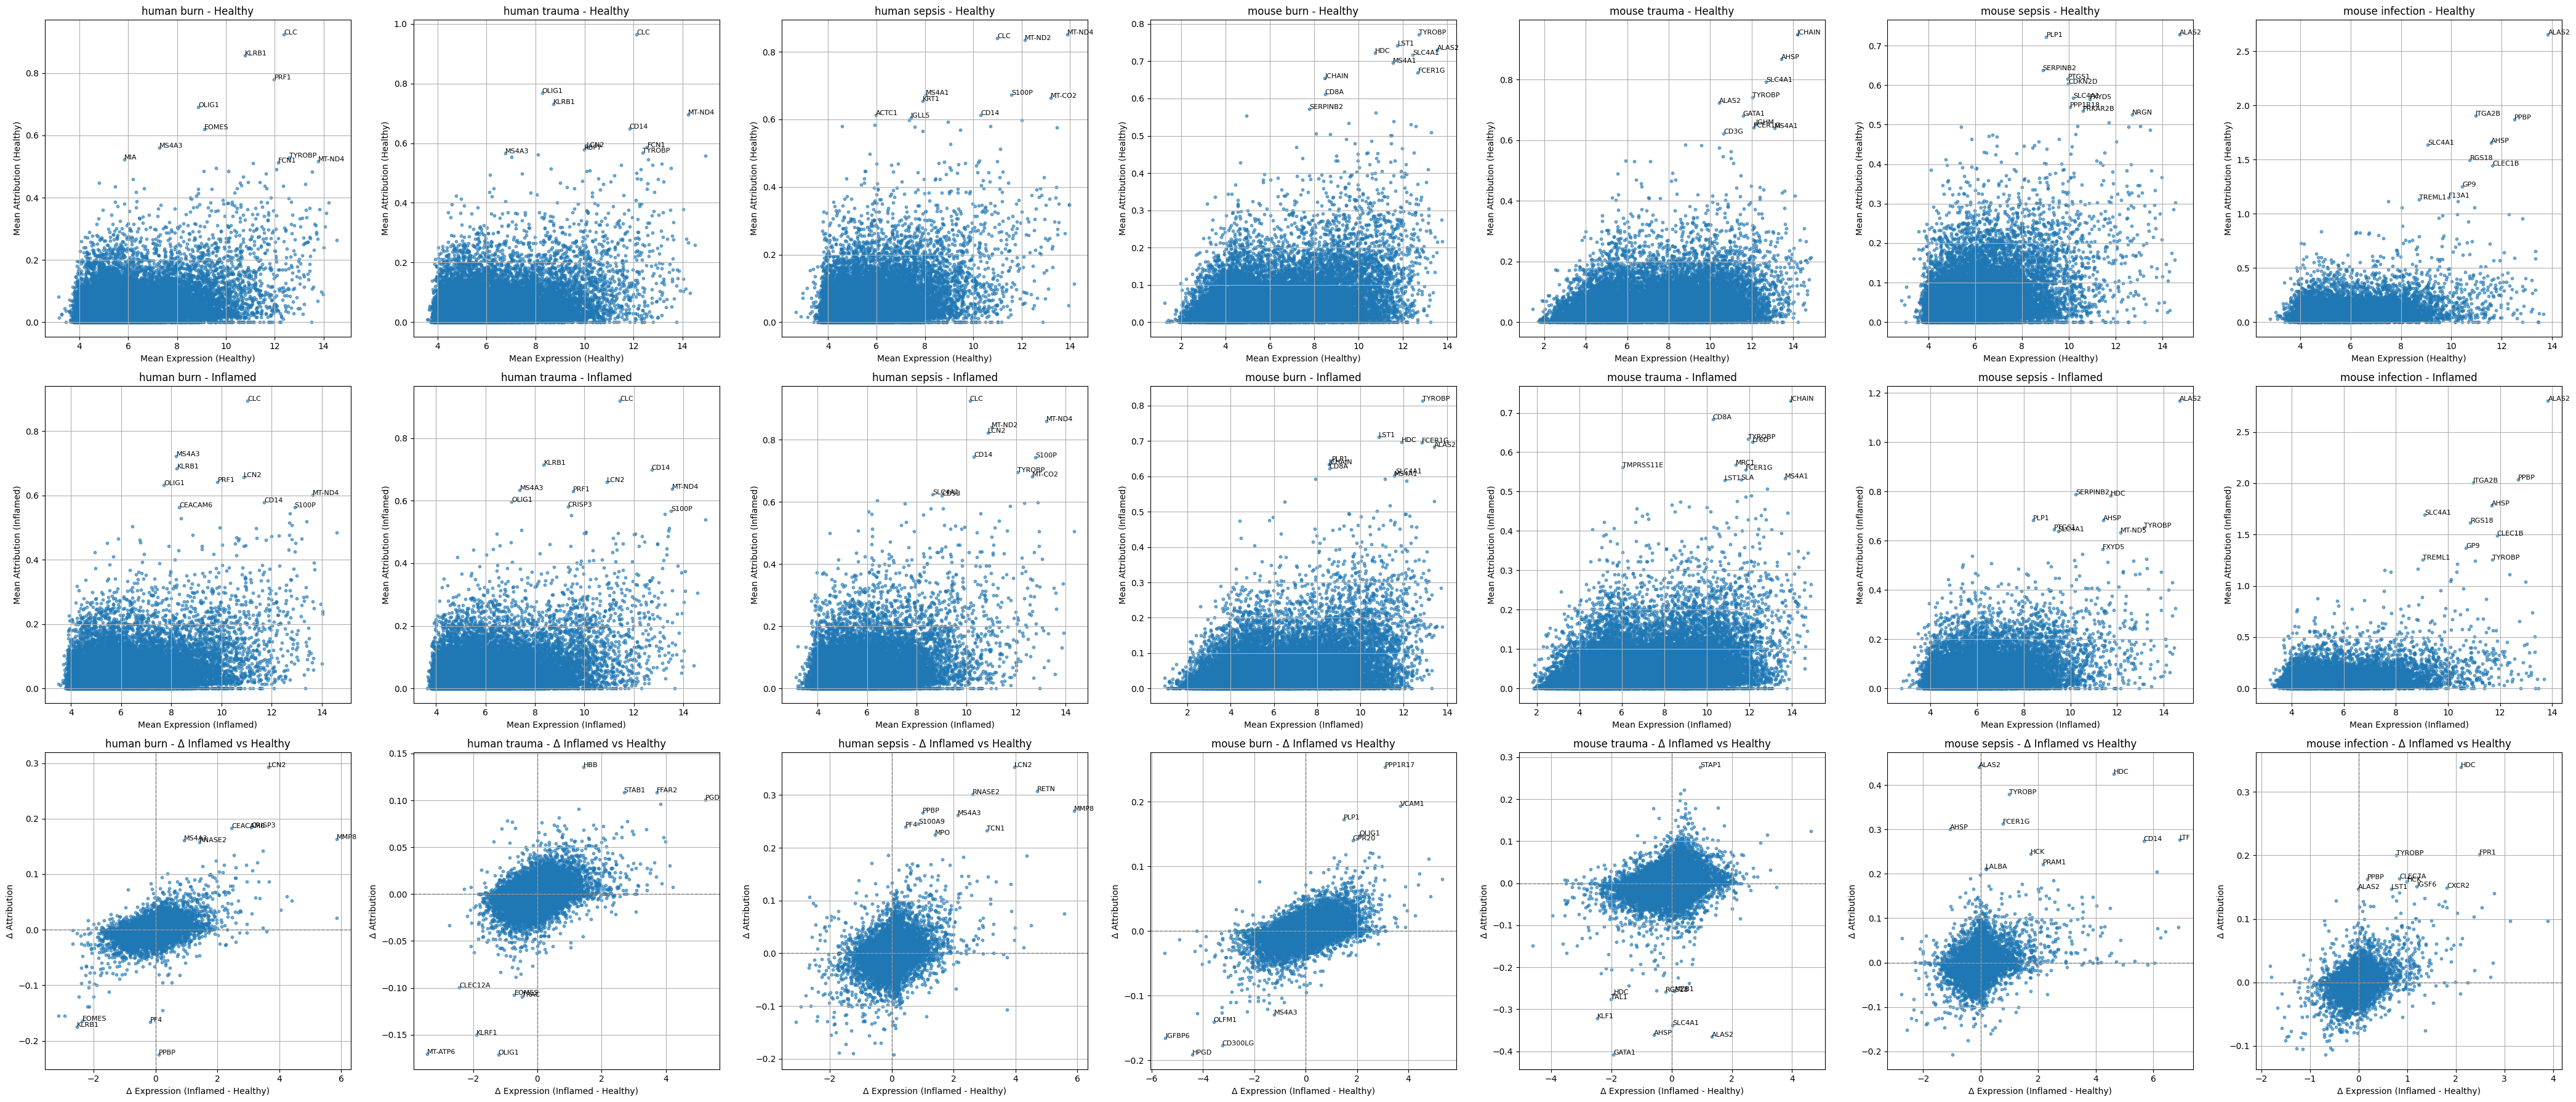

In [24]:
plot_all_datasets_attributions_vs_expression_by_condition(datasets)

##### Paper figures

In [27]:
def compute_delta_attributions(adata):
    A = adata.layers['attributions']
    if hasattr(A, "toarray"):  # convert sparse to dense
        A = A.toarray()

    # Restrict to genes in adata.var (intersected genes)
    common_genes = [g for g in adata.var.index if g in scim.gene_order]
    # get column indices in A
    gene_indices = [adata.var.index.get_loc(g) for g in common_genes]  # <- this
    A_sub = A[:, gene_indices]
    
    healthy_mask = adata.obs['group'] == 'control'
    inflamed_mask = adata.obs['group'] == 'inflammation'

    # Compute mean per condition
    delta = A_sub[inflamed_mask, :].mean(axis=0) - A_sub[healthy_mask, :].mean(axis=0)
    return pd.Series(delta, index=common_genes)

def compute_metrics(vec_x, vec_y):
    """
    Compute Pearson R², Spearman rho, and % same direction between two vectors.
    """
    r, _ = pearsonr(vec_x, vec_y)
    r2 = r**2
    same_direction = (vec_x * vec_y > 0).sum()
    percent_same = same_direction / len(vec_x) * 100
    rho, _ = spearmanr(vec_x, vec_y)
    return {'R2_Pearson': r2, 'Percent_Same_Direction': percent_same, 'Spearman_rho': rho}

def plot_metrics_text(ax, metrics):
    """
    Display metrics as text inside a subplot.
    """
    text = f"R²={metrics['R2_Pearson']:.2f}\n" \
           f"%Dir={metrics['Percent_Same_Direction']:.1f}\n" \
           f"Spearman={metrics['Spearman_rho']:.2f}"
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)

def plot_scatter_fc(ax, vec_x, vec_y):
    """
    Scatter plot of delta vectors with diagonal reference line.
    """
    ax.scatter(vec_x, vec_y, s=10, alpha=0.6)
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, color='red', lw=1)
    for spine in ax.spines.values():
        spine.set_visible(True)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

def get_delta_vectors(dataset_i, dataset_j):
    """
    Return delta vectors for a pair of datasets, aligned on intersecting genes.
    """
    delta_i = compute_delta_attributions(dataset_i['adata'])
    delta_j = compute_delta_attributions(dataset_j['adata'])

    # Align on intersecting genes
    common_genes = delta_i.index.intersection(delta_j.index)
    delta_i_aligned = delta_i.loc[common_genes].to_numpy()
    delta_j_aligned = delta_j.loc[common_genes].to_numpy()
    
    return delta_i_aligned, delta_j_aligned

def make_mimicry_grid(datasets_dict):
    """
    Create a comparison grid:
    - Diagonal: dataset names
    - Upper triangle: metrics (R² Pearson, Spearman, % same direction)
    - Lower triangle: scatter of delta attributions
    """
    dataset_names = list(datasets_dict.keys())
    n = len(dataset_names)
    fig, axes = plt.subplots(n, n, figsize=(3*n, 3*n))

    # Precompute delta vectors
    delta_vectors = {}
    for i in range(n):
        for j in range(i, n):
            if i == j:
                delta_vectors[(i,j)] = None  # or skip; diagonal
            else:
                delta_vectors[(i,j)] = get_delta_vectors(datasets_dict[dataset_names[i]],
                                                        datasets_dict[dataset_names[j]])

    # Diagonal: dataset names
    for i, name in enumerate(dataset_names):
        ax = axes[i,i]
        ax.text(0.5, 0.5, name.replace('_',' '), ha='center', va='center', fontsize=16, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)

    # Upper triangle: metrics
    for i in range(n):
        for j in range(i+1, n):
            ax = axes[i,j]
            vec_i, vec_j = delta_vectors[(i,j)]
            metrics = compute_metrics(vec_i, vec_j)
            plot_metrics_text(ax, metrics)

    # Lower triangle: scatter plots
    for i in range(1, n):
        for j in range(i):
            ax = axes[i,j]
            vec_i, vec_j = delta_vectors[(j,i)]  # reuse computed
            plot_scatter_fc(ax, vec_i, vec_j)

    plt.tight_layout()
    return fig


#### Unsupervised gene program discovery

* Use NMF to identify gene programs from attributions.
* Cluster samples
* Cluster genes

In [147]:
def run_joint_nmf(datasets_dict, n_factors=15, random_state=123):
    """
    Run joint NMF across multiple datasets on attribution matrices.

    Parameters
    ----------
    datasets_dict : dict
        Dictionary like:
        {
            "human_burn": {"adata": AnnData, "condition_col": ..., "healthy_label": ..., "inflamed_label": ...},
            "mouse_trauma": {...},
            ...
        }
        Each adata must have attributions in adata.layers['attributions'] and genes in adata.var.index.
    n_factors : int
        Number of NMF factors (topics / programs).
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    results : dict
        {
            "W" : cell loadings (DataFrame: cells x factors),
            "H" : gene programs (DataFrame: factors x genes),
            "metadata" : DataFrame with dataset/species/condition annotations
        }
    """
    # --- Step 1: find common genes ---
    gene_sets = [set(ds['adata'].var.index) for ds in datasets_dict.values()]
    common_genes = sorted(set.intersection(*gene_sets))
    print(f"Found {len(common_genes)} shared ortholog genes across datasets.")

    # --- Step 2: concatenate attribution matrices + metadata ---
    X_list = []
    meta_list = []

    for dataset_name, ds in datasets_dict.items():
        adata = ds['adata'][:, common_genes]  # subset to shared genes
        A = adata.layers['attributions']
        if hasattr(A, "toarray"):  # handle sparse
            A = A.toarray()

        X_list.append(A)

        meta = pd.DataFrame({
            "dataset": dataset_name,
            "species": dataset_name.split("_")[0],  # crude parse, or keep as-is
            "condition": adata.obs['group'].values
        }, index=adata.obs_names)

        meta_list.append(meta)

    X = np.vstack(X_list)  # cells x genes
    metadata = pd.concat(meta_list, axis=0)

    # --- Step 3: run NMF ---
    nmf = NMF(
        n_components=n_factors,
        init="nndsvda",
        random_state=random_state,
        max_iter=1000
    )
    W = nmf.fit_transform(X)   # cells x factors
    H = nmf.components_        # factors x genes

    # --- Step 4: wrap into DataFrames for convenience ---
    W_df = pd.DataFrame(W, index=metadata.index, columns=[f"Factor{i+1}" for i in range(n_factors)])
    H_df = pd.DataFrame(H, columns=common_genes, index=[f"Factor{i+1}" for i in range(n_factors)])

    return {
        "W": W_df,
        "H": H_df,
        "metadata": metadata
    }


In [162]:
def plot_factors_heatmap(W, metadata):
    """
    Heatmap of factor activity, ordering first by condition (healthy → inflamed), then dataset.
    
    Parameters
    ----------
    W : DataFrame
        Cell x Factor loadings from NMF.
    metadata : DataFrame
        Metadata with 'dataset' and 'condition' columns.
    """
    dataset_order = metadata['dataset'].unique()
    columns = []
    records = []

    # Loop over conditions first
    for condition in ['control', 'inflammation']:
        for ds in dataset_order:
            ds_mask = metadata['dataset'] == ds
            W_ds = W.loc[ds_mask, :]
            meta_ds = metadata.loc[ds_mask, :]
            mask = meta_ds['condition'] == condition
            if mask.sum() > 0:
                mean_activity = W_ds.loc[mask, :].mean(axis=0)
                records.append(mean_activity)
                columns.append(f"{ds}_{condition}")

    heatmap_df = pd.DataFrame(records, index=columns).T  # rows = factors

    # Plot
    plt.figure(figsize=(12,8))
    sns.heatmap(heatmap_df, annot=False, cmap='coolwarm', center=0,
                cbar_kws={'label': 'Mean factor activity'})
    plt.xlabel("Dataset / Condition")
    plt.ylabel("Factors")
    plt.title("Factor Activity per Condition and Dataset")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_factors_violin(W, metadata):
    """
    Violin plots of factor activation per factor, faceted by factor, with control vs. inflammation separation.
    
    Assumes metadata has:
        - 'dataset' column
        - 'condition' column with values 'control' or 'inflammation'
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd

    # Melt W into long format
    df_long = W.copy()
    df_long['cell'] = df_long.index
    df_long = df_long.merge(metadata[['dataset','condition']], left_on='cell', right_index=True)
    df_long_melt = df_long.melt(
        id_vars=['cell','dataset','condition'],
        var_name='Factor',
        value_name='Activation'
    )

    # Explicit x-axis ordering: condition first, then dataset
    groups_order = ['control', 'inflammation']
    datasets_order = metadata['dataset'].unique()
    x_order = []
    for grp in groups_order:
        for ds in datasets_order:
            col_name = f"{grp}_{ds}"
            if ((df_long_melt['condition'] == grp) & (df_long_melt['dataset'] == ds)).any():
                x_order.append(col_name)

    # Create combined column and set as categorical
    df_long_melt['Dataset_Cond'] = df_long_melt['condition'].astype(str) + "_" + df_long_melt['dataset'].astype(str)
    df_long_melt['Dataset_Cond'] = pd.Categorical(df_long_melt['Dataset_Cond'], categories=x_order, ordered=True)

    n_healthy = sum(['control' in col for col in x_order])

    # Facet grid by factor
    n_cols = 3
    g = sns.FacetGrid(df_long_melt, col="Factor", col_wrap=n_cols, sharey=True, height=4)
    g.map_dataframe(
        sns.violinplot,
        x="Dataset_Cond",
        y="Activation",
        inner="quartile",
        dodge=False,
        palette="Set2"
    )

    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("", "Factor Activation")

    # Rotate x labels and draw vertical line between control and inflammation
    for ax in g.axes.flatten():
        plt.setp(ax.get_xticklabels(), rotation=60, ha='right')
        ax.axvline(n_healthy - 0.5, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

Found 8044 shared ortholog genes across datasets.


/home/amoneim/.pyenv/versions/signature/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


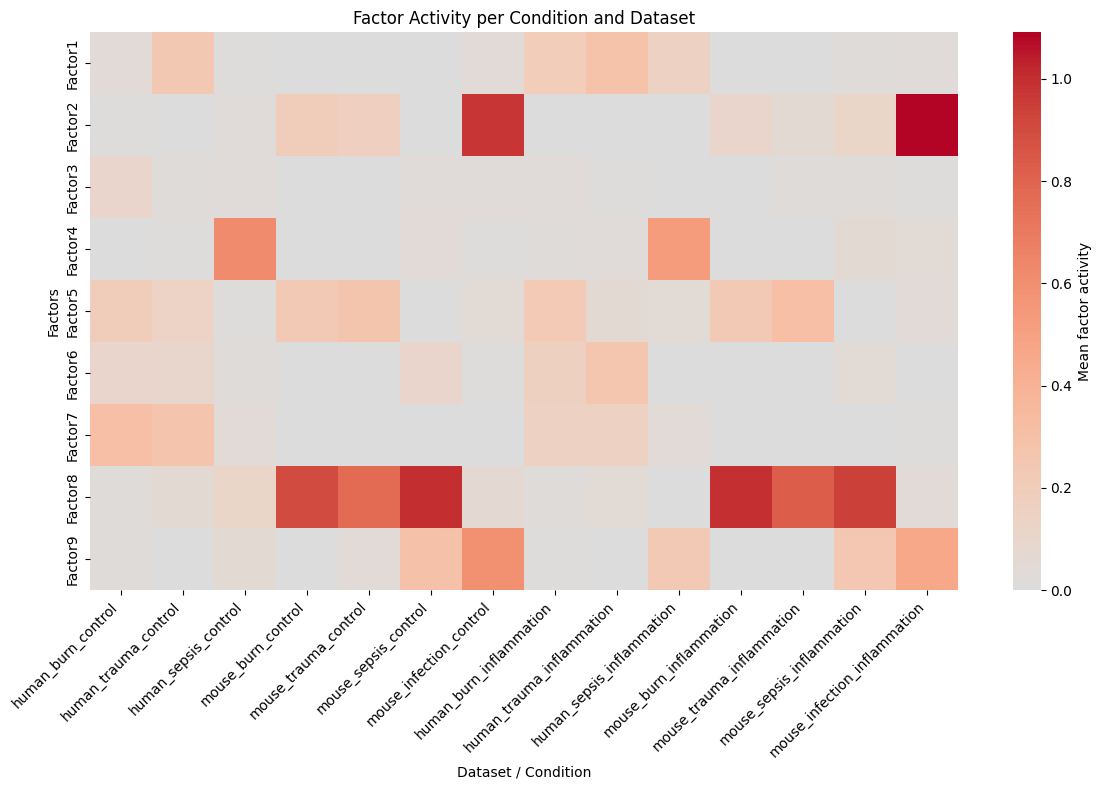

/home/amoneim/.pyenv/versions/signature/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/amoneim/.pyenv/versions/signature/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/amoneim/.pyenv/versions/signature/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/amoneim/.pyenv/versions/signature/lib/python3.10/site-package

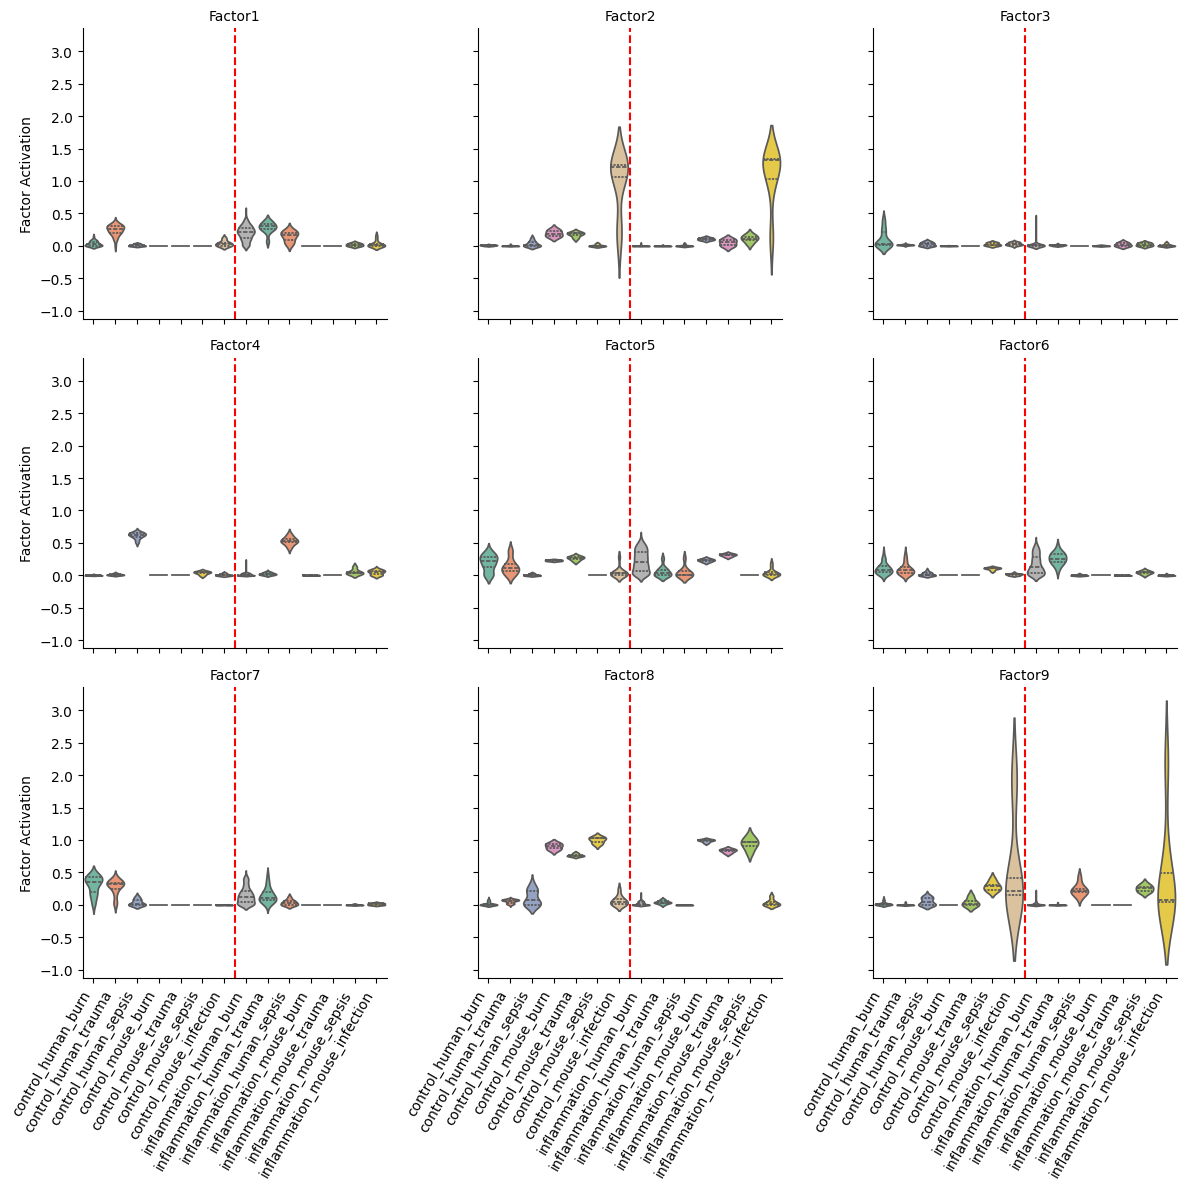

In [165]:
nmf_result = run_joint_nmf(datasets, n_factors=9, random_state=221)
plot_factors_heatmap(nmf_result['W'], nmf_result['metadata'])
plot_factors_violin(nmf_result['W'], nmf_result['metadata'])

#### Biological interpretation

* Pathway enrichment analysis of gene programs
* Find shared vs. unique programs between human and mouse